In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import time

In [2]:
""" Useful functions """
# boxcar function
def BC(x):
    return 1*(x+0.5>=0)-1*(x-0.5>=0)

# Heaviside function
def HS(x):
    return 0+x>=0;

# ramp function
def Ramp(x):
    return x*BC(x-1/2)+HS(x-1);

In [81]:
class FaultProblem:
    def __init__(self,rho,cs,mu,nu,K_tau,K_sig,eta,fo,Vo,cca,ccb,Drs,sigma,Vpl,dgf,dip,y2,y3,y2c,y3c,y2p,y3p):

        # bulk properties
        self.rho = rho
        self.cs = cs 
        self.mu = mu
        self.nu = nu
        self.K_tau = K_tau
        self.K_sig = K_sig
        self.eta = eta
        
        #fault properties
        self.fo = fo
        self.Vo = Vo
        self.cca = cca
        self.ccb = ccb
        self.Drs = Drs
        self.sigma = sigma
        self.Vpl = Vpl
        
        # number of parameters of interest
        self.dgf = dgf
        self.y2  = y2
        self.y3  = y3
        self.y2c = y2c
        self.y3c = y3c
        self.y2p = y2p
        self.y3p = y3p

In [82]:
"""                                                      
                     Set up Model Domain                     
                                                    
 We consider a 2D plain-strain dipping fault 
 that is infinitely long in the along-strike direction 
 in the x1 direction, extending from the surface to a fixed  
 depth, with slip only varying in the x3 = z direction (down-dip)
"""

### Bulk Properties
# density (kg/m^3)
rho = 2670

# shear wave speed (m/s)
cs = 3464

# shear modulus (MPa)
mu = rho*cs**2/1e6

# Poisson's ratio
nu = 0.25

pi = np.pi

### Mesh Geometry
Wf = 40e3                                                 # Width of rate-and-state fault
M = 800                                                   # Number of cells
dw = Wf/M                                                 # Spatial discretization along fault
W=np.ones((M,))*dw                                       # Width of slip patch

dip_angle = 60                                           # Angle with respect to horizontal (degrees) - 90 = vertical
dip = dip_angle*np.ones((M,))
dipr = dip * np.pi / 180

y2 = np.linspace(0,M-1,M).reshape( (M,) )*dw * np.cos(dipr) # horizontal for top-left of source patch
y3 = np.linspace(0,M-1,M).reshape( (M,) )*dw * np.sin(dipr) # vertical coordinate for top-left of source patch

y2c = (np.linspace(0,M-1,M).reshape( (M, ) )*dw+0.5*dw) * np.cos(dipr)  # vertical center coordinate for source patch
y3c = (np.linspace(0,M-1,M).reshape( (M, ) )*dw+0.5*dw) * np.sin(dipr)  # vertical center coordinate for source patch

y2p = np.linspace(0,M,M+1).reshape( (M+1, ) )*dw * np.cos(dip_angle*np.pi/180)      # for plotting
y3p = np.linspace(0,M,M+1).reshape( (M+1, ) )*dw * np.sin(dip_angle*np.pi/180)      # for plotting

# Surface points (virtual GPS receivers crossing the fault in x)
nsta = 100
eps = 1e-6  # just to shift coordinates off of x2 = 0
xGPSR =  (200e3*np.tan(eps+np.linspace(0,nsta/2,nsta)*pi/(2*nsta)))
xGPSL = (-200e3*np.tan(eps+np.linspace(0,nsta/2,nsta)*pi/(2*nsta)))
xGPS = np.concatenate((np.flipud(xGPSL),xGPSR),axis=0)
zGPS = np.zeros(len(xGPS))

(-5.0, 25.0)

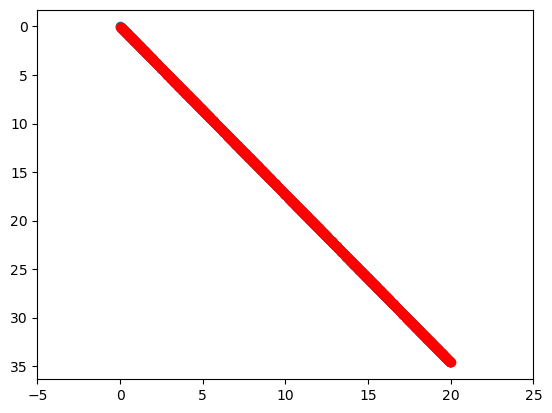

In [83]:
fig, ax = plt.subplots(1,1)

ax.plot(y2/1e3,y3/1e3,'o')
ax.plot(y2c/1e3,y3c/1e3,'o',color='red')
ax.invert_yaxis()
ax.set_xlim(-5, 25)


In [84]:
def EdgeStress(x_src, z_src, dip, W_src, x_rec, z_rec, mu, nu):
    """
    Computes stresses at (x, z) due to an edge dislocation with unit slip (m)
    All length inputs should be in the same units; otherwise stresses will be off by a constant.
    Nu is Poisson's ratio and mu is shear modulus. If mu is not specified, it defaults to one.

    z_src = Depth of updip end
    x_src = Horizontal position of updip end
    W_src = Downdip width
    dip = Dip (radians)
        
    The vertical axis is reckoned NEGATIVE down.
    """
    
    # Make sure vertical coordinates are negative
    rec_z = -np.abs(z_rec)
    src_z = -np.abs(z_src)
    
    # Define Constants
    sd = np.sin(dip)
    cd = np.cos(dip)
    a1 = np.array([sd, -sd]) * mu / (2 * np.pi * (1 - nu))
    a2 = np.array([cd, -cd]) * mu / (2 * np.pi * (1 - nu))
 
    #Xarr = np.array([x_src, x_src + src_z * cd], dtype=object)
    Xarr = np.array([x_src, x_src + W_src * cd], dtype=object)
    Zarr = np.array([src_z, src_z - W_src * sd], dtype=object)
    
    
    Sxx = np.zeros_like(x_rec)
    Sxz = np.zeros_like(x_rec)
    Szz = np.zeros_like(x_rec)
    
    # Compute stresses
    for i in range(2):
        zmZ = rec_z - Zarr[i]
        zmZ2 = zmZ ** 2
        
        zpZ = rec_z + Zarr[i]
        zpZ2 = zpZ ** 2
        
        xmX = x_rec - Xarr[i]
        xmX2 = xmX ** 2
        
        r12 = zmZ2 + xmX2
        r22 = zpZ2 + xmX2
        
        r122 = r12 ** 2
        r222 = r22 ** 2
        r223 = r222 * r22

    
        
        b1 = xmX * (3 * zmZ2 + xmX2) / r122
        b2 = xmX * (3 * zpZ2 + xmX2) / r222
        b3 = 4.0 * Zarr[i] * rec_z * xmX * (3.0 * zpZ2 - xmX2) / r223
        b4 = zmZ * (zmZ2 - xmX2) / r122
        b5 = zpZ * (zpZ2 - xmX2) / r222
        a3 = (3.0 * rec_z + Zarr[i]) * zpZ2 * zpZ - 6.0 * rec_z * zpZ * xmX2 - xmX2 ** 2
        b6 = 2.0 * Zarr[i] * a3 / r223
        
        c1 = xmX * (zmZ2 - xmX2) / r122
        c2 = xmX * (zpZ2 - xmX2) / r222
        
        a4 = (2.0 * Zarr[i] - rec_z) * zpZ2 + (3.0 * rec_z + 2.0 * Zarr[i]) * xmX2
        
        c3 = 4.0 * Zarr[i] * xmX * a4 / r223
        c4 = zmZ * (zmZ2 + 3.0 * xmX2) / r122
        c5 = zpZ * (zpZ2 + 3.0 * xmX2) / r222
        
        a5 = zmZ * zpZ2 * zpZ - 6.0 * rec_z * zpZ * xmX2 + xmX2 ** 2
        c6 = 2.0 * Zarr[i] * a5 / r223
        
        Sxx += a1[i] * ( c1 - c2 + c3) + a2[i] * (-c4 + c5 + c6)
        Sxz += a1[i] * ( b4 - b5 - c6) + a2[i] * (-c1 + c2 - b3)
        Szz += a1[i] * (-b1 + b2 + b3) + a2[i] * (-b4 + b5 - b6)
    
    return Sxx, Sxz, Szz

In [85]:
def LDdispHS(x_rec, z_rec, x_src, z_src, W, dip, nu):
    """
    Computes the influence (displacement) of a single planar line crack
    shearing and/or opening on the surrounding points in a half-space at 0.

    Arguments:
    x_rec, z_rec    - Observation points locations in real Cartesian coordinates (z must be below 0).
    x_src, z_src  - Element midpoint location in real coordinates (z_src must be below 0).
    W       - Element's half length.
    dip    -  Angle of the element away from the x-axis (radians).
    nu      - Poisson's ratio.

    Returns:
    Disp    - Displacement caused by the movement of the dislocation at the observation points [Ux, Uy].
    """
    
    if np.any(z_rec > 0):
        raise ValueError('Half-space solution: Z coordinates must be negative!')

    # Define material constant used in calculating influence coefficients.
    con = 1 / (4 * np.pi * (1 - nu))
    sb = np.sin(dip)
    cb = np.cos(dip)
    s2b = np.sin(2 * dip)
    c2b = np.cos(2 * dip)
    s3b = np.sin(3 * dip)
    c3b = np.cos(3 * dip)

    # Define array of local coordinates for the observation grid relative to the midpoint and orientation of the element.
    XB =  (x_rec - x_src) * cb + (z_rec - z_src) * sb
    ZB = -(x_rec - x_src) * sb + (z_rec - z_src) * cb

    # Coordinates of the image dislocation
    XBi = (x_rec - x_src) * cb - (z_rec + z_src) * sb
    ZBi = (x_rec - x_src) * sb + (z_rec + z_src) * cb

    # Fix roundoff errors in ZBi and ZB from trig function problems
    ZBi[np.abs(ZBi) < 1e-10] = 0
    ZB[np.abs(ZB)   < 1e-10] = 0

    # Calculate derivatives of the function f(x,z)
    Z2 = ZB ** 2
    XMa = XB - W
    XPa = XB + W
    XMa2 = XMa ** 2
    XPa2 = XPa ** 2
    R1S = XMa2 + Z2
    R2S = XPa2 + Z2

    # Same thing for the image dislocation
    Z2i = ZBi ** 2
    XMai = XBi - W
    XPai = XBi + W
    XMa2i = XMai ** 2
    XPa2i = XPai ** 2
    R1Si = XMa2i + Z2i
    R2Si = XPa2i + Z2i

    R1S2i = R1Si**2
    R2S2i = R2Si**2

    FF2 = con * (np.log(np.sqrt(R1S)) - np.log(np.sqrt(R2S)))

    # Flag all observation points for which ZB is not 0
    i1 = np.nonzero(ZB)
    i2 = np.nonzero((ZB == 0) & (np.abs(XB) < W))
    i3 = np.nonzero((ZB == 0) & (np.abs(XB) > W))

    FF3 = np.zeros_like(ZB)
    FF3[i1] = np.arctan2(ZB[i1], XMa[i1]) - np.arctan2(ZB[i1], XPa[i1])
    FF3[i2] = np.pi
    FF3[i3] = 0
    FF3 = -con * FF3.T
    FF3 = FF3.reshape(x_rec.shape)

    FF4 = con * (ZB / R1S - ZB / R2S)
    FF5 = con * (XMa / R1S - XPa / R2S)

    # Calculate intermediate functions for the image dislocation
    FF2i = con * (np.log(np.sqrt(R1Si)) - np.log(np.sqrt(R2Si)))

    i1i = np.nonzero(ZBi)
    i2i = np.nonzero((ZBi == 0) & (np.abs(XBi) < W))
    i3i = np.nonzero((ZBi == 0) & (np.abs(XBi) > W))

    FF3i = np.zeros_like(ZBi)
    FF3i[i1i] = np.arctan2(ZBi[i1i], XMai[i1i]) - np.arctan2(ZBi[i1i], XPai[i1i])
    FF3i[i2i] = np.pi
    FF3i[i3i] = 0
    FF3i = -con * FF3i.T
    FF3i = FF3i.reshape(x_rec.shape)

    FF4i = con * (ZBi / R1Si - ZBi / R2Si)
    FF5i = con * (XMai / R1Si - XPai / R2Si)

    FF6i = con * ((XMa2i - Z2i) / R1S2i - (XPa2i - Z2i) / R2S2i)
    FF7i = 2 * con * ZBi * (XMai / R1S2i - XPai / R2S2i)

    pr1 = 1 - 2 * nu
    pr2 = 2 * (1 - nu)
    pr3 = 3 - 4 * nu

    Ux =  (-pr1 * sb * FF2 + pr2 * cb * FF3 + ZB * (sb * FF4 - cb * FF5)) 
    Uz =  ( pr1 * cb * FF2 + pr2 * sb * FF3 - ZB * (cb * FF4 + sb * FF5)) 

    Uxi_s = (pr1 * sb * FF2i - pr2 * cb * FF3i + \
            (pr3 * (z_rec * s2b - ZB * sb) + 2 * z_rec* s2b) * FF4i + \
            (pr3 * (z_rec * c2b - ZB * cb) - z_rec* (1 - 2 * c2b)) * FF5i + \
             2 * z_rec* (z_rec * s3b - ZB * s2b) * FF6i - \
             2 * z_rec* (z_rec * c3b - ZB * c2b) * FF7i)
    
    Uzi_s = (-pr1 * cb * FF2i - pr2 * sb * FF3i - \
            (pr3 * (z_rec * c2b - ZB * cb) + z_rec* (1 - 2 * c2b)) * FF4i + \
            (pr3 * (z_rec * s2b - ZB * sb) - 2 * z_rec* s2b) * FF5i + \
            2 * z_rec* (z_rec * c3b - ZB * c2b) * FF6i + \
            2 * z_rec* (z_rec * s3b - ZB * s2b) * FF7i)

    Ux += Uxi_s
    Uz += Uzi_s

    Disp = np.column_stack((Ux.flatten(), Uz.flatten()))
    return Disp


In [86]:
"""
                       Kernels                        
"""                      
K_tau = np.zeros((M,M))                  # shear stress kernels
K_sig = np.zeros((M,M))                  # normal stress kernels

kux = np.zeros((xGPS.size,M))
kuz = np.zeros((xGPS.size,M))

t = np.zeros((M,2))
for k in range(M):
    # Evaluate the stress at the center of the slip patches
    # Coordinate from source is top of patch
    Sxx, Sxz, Szz = EdgeStress(y2[k], y3[k], dipr[k], W[k], y2c, y3c, mu, nu)
    
    # traction on receivers
    t[:,0] = (Sxx.flatten()*np.sin(dipr)+Sxz.flatten()*np.cos(dipr))
    t[:,1] = (Sxz.flatten()*np.sin(dipr)+Szz.flatten()*np.cos(dipr))

    # project to shear and normal stress components
    K_tau[:,k] =  -np.cos(dipr)*t[:,0] + np.sin(dipr)*t[:,1]
    K_sig[:,k] =   np.sin(dipr)*t[:,0] + np.cos(dipr)*t[:,1]

    # Displacement kernels
    Disp = LDdispHS(xGPS, zGPS, y2c[k], y3c[k], 0.5*W[k], dipr[k], nu) 
    
    kux[:,k] = Disp[:,0];
    kuz[:,k] = Disp[:,1];


In [87]:
np.min(K_sig)

-30.078752671383484

In [102]:
def setFaultProp(y3,dipr):
    """                                                    
                    Fault Properties                  
    """

    # reference friction coefficient
    fo=0.6*np.ones(y3.shape)

    # Dieterich-Ruina R+S frictional parameters (velocity-weakening friction)
    cca=1e-2+Ramp((y3*np.sin(dipr)-15e3)/3e3)*(0.025-0.01)
    ccb=0.015*np.ones(y3.shape)

    # effective normal stress (MPa)
    sigma=50.0*np.ones((y3.size,))

    # characteristic weakening distance (m)
    Drs=8e-3*np.ones(y3.shape)

    # plate rate (m/s)
    Vpl=1e-9*np.ones(y3.shape)

    # reference slip rate (m/s)
    Vo=1e-6*np.ones(y3.shape)

    # Radiation damping coefficient
    eta = mu/(2*cs)

    # Estimates of some key parameters
    VWp = np.argwhere(ccb>cca) # VW region
    VWp = VWp[:,0]
    # Critical nucleation size ( h* = pi/2 G b D_rs / (b-a)^2 / sigma )
    hstar=np.min(pi/2*mu*Drs[VWp]*ccb[VWp]/(ccb[VWp]-cca[VWp])**2/sigma[VWp])

    # Quasi-static cohesive zone ( coh0 = 9/32 G D_rs /(b*sigma) ) 
    # Note that for this QD simulation the cohesive zone will not change,
    # which would not be the case for a fully dynamic simulation
    Lvw = (y3[VWp[-1]]-y3[VWp[0]]) # size of VW region
    coh = np.min(9/32*pi*mu*Drs[VWp]/ccb[VWp]/sigma[VWp])

    # Estimate of recurrence time ( T ~ 5(b-a)*sigma / mu * 0.5 Lvw/Vpl ) 
    Ti = 5*np.mean((ccb[VWp]-cca[VWp])*sigma[VWp])*0.5*Lvw/(mu*np.mean(Vpl[VWp]))

    # Print information about discretization
    print("Grid size = %.2f (m)\n" % (dw))
    print("VW zone = %.2f (km)\n" % (Lvw/1e3))
    print("Critical nucleation size = %.2f (m)\n" % (hstar))
    print("QS Cohesive zone = %.2f (m)\n" % (coh))
    print("Est. Recurrence time = %.2f (yr)\n" % (Ti/3.15e7))

    return fo, cca, ccb, sigma, Drs, Vpl, Vo, eta

In [103]:
def DieterichRuinaRegAging(t,y,fp):
    """
    This function describes the evolution of the ordinary
    differential equation y' = f(t,y), where the state 
    vector y is 

            /        s             \
        y = |       tau            |
            |       sig            |
            | log(theta Vo / D_rs) |
            \    log(V / Vo)      /

     based on the regularized form of Dieterich-Ruina rate-and-state friction 
     and using the aging law

     Velocity is determined by the balance of shear resistance and shear stress
     Resistance : tau = a sigma asinh( V/2Vo exp( (fo + b psi ) / a))
     Stress     : tau = tauo + f(z,t) - eta*V  
     Where we use radiation damping to approximate the inertial terms
     as the quasi-dynamic approximation with f(z,t) = K(delta - Vpl*t)

     This is done by taking the time-derivative of both equations and equating
     the two.

       a sigma  alpha/ sqrt(1 + alpha^2) ( 1/V dV/dt + b/a dPhi/dt) 
                _ 
     
                       = K( V - Vpl) - eta dV/dt

     where 
          alpha = V / 2Vo exp( ( fo + b phi) / a)



     Note this form assumes no time variation in sigma, the frictional
     parameters, or the loading plate rate. Loading is done purely through
     back slip at plate rate Vpl.

     Instead of directly integrating numerically the aging law

        d theta / dt = 1 - |V| theta / D_rs

     as is, we operate the following change of variable

        phi = ln (theta Vo / D_rs)

     where we obtain the evolution law for the new variable
 
        d phi / dt = ( Vo exp(-phi) - V ) / D_rs

     Given the regularized form of Dieterich-Ruina R+S we can express,
        1 dV      K (V - Vpl) - b sigma dphi / dt Q
        - --  =  ----------------------------------
        V dt           a sigma Q  + eta V
  
     where

                                1
        Q = -----------------------------------------------
            /                                             \(1/2)
            |  1 + [2 Vo / V exp(-(fo + b phi) / a )]^2   |
            \                                             /
 
     Note that d/dt log(V/Vo) = 1/V dV/dt, and is much more efficient to
     integrate than dV/dt alone
    """
    # State variable
    th=y[3::fp.dgf]

    # Slip rate
    V = fp.Vo*np.exp(y[4::fp.dgf])

    # Current normal stress
    sig_n = y[2::fp.dgf]

    # Initialize Time Derivative
    yp=np.zeros(y.shape)

    # Slip
    yp[0::fp.dgf]=V

    # State Variable
    dth = (fp.Vo*np.exp(-th)-np.abs(V))/fp.Drs
    yp[3::fp.dgf]=dth

    # Slip Velocity
    func_tau = np.matmul(fp.K_tau,(V-fp.Vpl))
    func_sig = np.matmul(fp.K_sig,(V-fp.Vpl))
    
    f1=2*fp.Vo/V*np.exp(-(fp.fo+fp.ccb*th)/fp.cca)
    f2=1/np.sqrt(1+f1**2)
    f3=func_sig*fp.cca*np.arcsinh(1/f1)

    yp[4::fp.dgf] = (func_tau - fp.ccb*sig_n*dth*f2 - f3)/ \
                    (fp.cca*sig_n*f2 + fp.eta*V)


    # Evolution of shear stress 
    yp[1::fp.dgf]=func_tau - fp.eta*V*yp[4::fp.dgf];

    # Evolution of normal stress 
    yp[2::fp.dgf]=func_sig;

    return yp

In [104]:
"""                     Numerical Solution                

     Use Runge-Kutta 4th / 5th order accurate integration to 
     solve the ODE time integration problem with adaptive time-steps
         yp = f(t,y)
         Y = [slip; stress; state variable; log10(slip rate / ref slip rate)]
"""

fo, cca, ccb, sigma, Drs, Vpl, Vo, eta = setFaultProp(y3,dipr)
# Degrees of Freedom                                                   
dgf=5

fp = FaultProblem(rho,cs,mu,nu,K_tau,K_sig,eta,fo,Vo,cca,ccb,Drs,sigma,Vpl,dgf,dipr,y2,y3,y2c,y3c,y2p,y3p)

# Initial conditions (start at steady-state with zero slip)
Y0=np.zeros(M*dgf,);   
Y0[0::dgf]=np.zeros(M,);   
Y0[1::dgf]=np.max(cca)*sigma*np.arcsinh(Vpl/Vo/2*np.exp((fo+ccb*np.log(Vo/Vpl))/np.max(cca))) + eta*Vpl
Y0[2::dgf]=sigma
Y0[3::dgf]=cca/ccb*np.log(2*Vo/Vpl*np.sinh((Y0[1::dgf]-eta*Vpl)/cca/sigma))-fo/ccb
Y0[4::dgf]=np.log(Vpl/Vo)

def yp(t,Y):
    yp = DieterichRuinaRegAging(t,Y,fp)
    return yp
 

# ODE45 Settings
t0 = 0              # initial time
tf = 1500*3.15e7     # final time
dtmax = 3.15e7

start = time.time()
sol = sp.integrate.solve_ivp(yp, [t0, tf], Y0, method='RK45', max_step=dtmax, rtol=1e-8, atol=1e-6, vectorized=False, first_step=1e-5)
end = time.time()
print(f'Finished, calculaton time: {end-start:.3f} s')


Grid size = 50.00 (m)

VW zone = 18.45 (km)

Critical nucleation size = 4831.23 (m)

QS Cohesive zone = 301.95 (m)

Est. Recurrence time = 11.07 (yr)

Finished, calculaton time: 76.961 s


In [105]:
"""                        Prepare Figures                       """
Y = np.transpose(np.asarray(sol.y))
t = np.asarray(sol.t)
Vt = np.multiply(Vo,np.exp(Y[:,4::dgf]))        # Slip rate (m/s)
taut = Y[:,1::dgf]                              # Shear stress (MPa)
Vmax = np.zeros(t.size,);                       # Maximum slip rate (m/s)
Vcenter = Vt[:,int(np.floor(M/2))]             # Slip rate at center of VW region
for ti in range(t.size):
    Vmax[ti] = np.max(Vt[ti,:]);

tcenter = taut[:,int(np.floor(M/2))]
# GPS time series (displacement in x1 direction)
shistory = Y[:,0::dgf]
UxGPS = np.matmul(kux,np.transpose(shistory))
UzGPS = np.matmul(kuz,np.transpose(shistory))


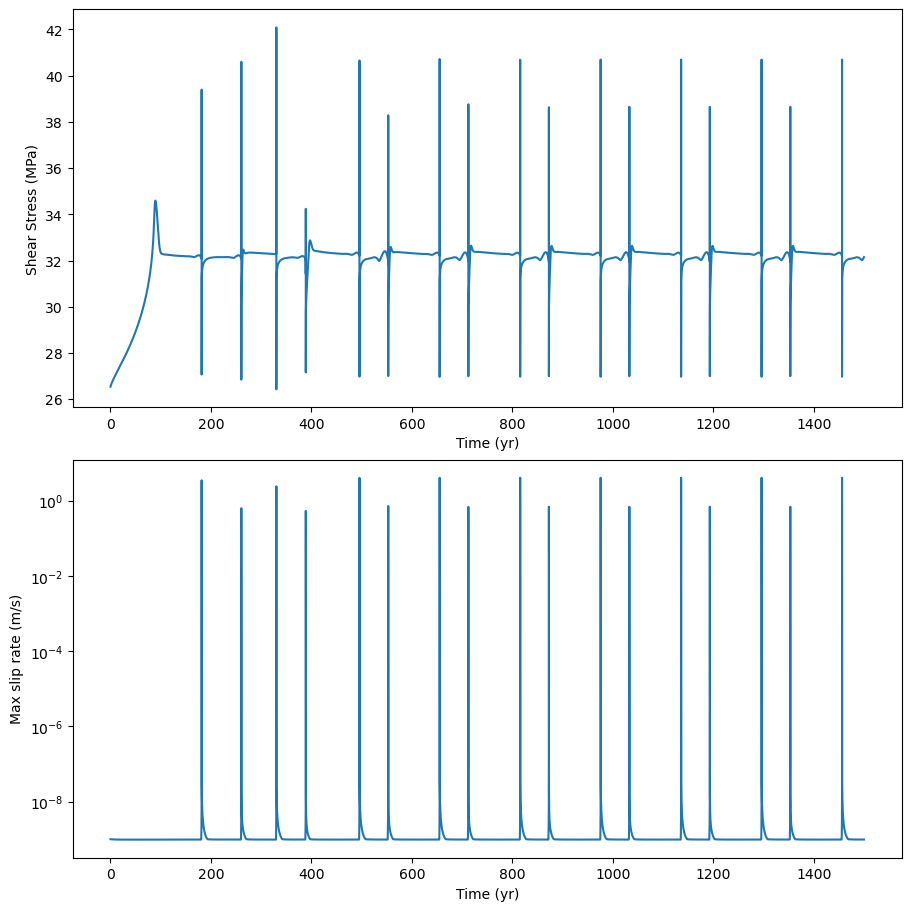

In [106]:
# Plot maximum slip rate along the fault over time
fig,ax = plt.subplots(2,1,figsize=[9,9],constrained_layout=True)  

d = ax[0].plot(t/3.15e7,tcenter)
ax[0].set_xlabel('Time (yr)')
ax[0].set_ylabel('Shear Stress (MPa)')
ax[0].set_yscale('linear')

d = ax[1].plot(t/3.15e7,Vmax)
ax[1].set_xlabel('Time (yr)')
ax[1].set_ylabel('Max slip rate (m/s)')
ax[1].set_yscale('log')  
              
#plt.tight_layout()
plt.show()

In [ ]:
# Plot space-time colormaps of fault slip rate
fig,ax = plt.subplots(2,1,figsize=[9,9],constrained_layout=True)   



# First plot colormap of slip rate over space and time
axs = ax[0]
c = axs.pcolor( t/3.15e7,y3p/1e3,np.transpose(np.log10(Vt[0:-1,:])), cmap='viridis', shading='flat')
axs.set_title('Log10 Slip Velocity (m/s)')
axs.set_xlabel('Time (yr)')
axs.set_ylabel('Depth (km)')
axs.invert_yaxis()
cb1 = fig.colorbar(c, ax=axs)
cb1.set_label('Slip rate (m/s)')

# Plot maximum slip rate along the fault over time
axs = ax[1]
d = axs.plot(t/3.15e7,np.log10(Vmax))
axs.set_xlabel('Time (yr)')
axs.set_ylabel('Max slip rate (m/s)')
              
#plt.tight_layout()
plt.show()

In [ ]:
# Let's make the same plot but in the time-step domain rather than time
fig,ax = plt.subplots(2,1,figsize=[9,9],constrained_layout=True)   

ndts = np.linspace(0,t.size-1,t.size).reshape( (t.size, ) )

# First plot colormap of slip rate over space and time
axs = ax[0]
c = axs.pcolor( ndts,y3p/1e3,np.transpose(np.log10(Vt[0:-1,:])), cmap='viridis', shading='flat')
axs.set_title('Log10 Slip Velocity (m/s)')
axs.set_xlabel('Time Step')
axs.set_ylabel('Depth (km)')
axs.invert_yaxis()
cb1 = fig.colorbar(c, ax=axs)
cb1.set_label('Slip rate (m/s)')

# Plot maximum slip rate along the fault over time
axs = ax[1]
d = axs.plot(ndts,np.log10(Vmax))
axs.set_xlabel('Time Step')
axs.set_ylabel('Max slip rate (m/s)')
              
plt.show()

In [ ]:
""" Let's plot some synthetic GPS time series """
dtsamp = 2.628e6           # 1 month sampling
t0rec = 150*3.15e7         # Initial time for record
MaxRecordT = 400*3.15e7    # 400 years time series
RecordT = t0rec + np.arange(0,MaxRecordT,dtsamp)
tindx = np.zeros(RecordT.size,)

# Create an array sampling time steps of fault displacement for the GPS records
for tstep in range(RecordT.size):
    tindx[tstep] = np.searchsorted(t, RecordT[tstep], side="left")-1


fig,ax = plt.subplots(3,2,figsize=[9,10],constrained_layout=True) 

#UxGPS = np.matmul(kux,np.transpose(shistory))
#UzGPS = np.matmul(kuz,np.transpose(shistory))

cmap = plt.get_cmap("jet", len(RecordT))
norm = mpl.colors.Normalize(vmin=min(RecordT/3.15e7), vmax=max(RecordT/3.15e7)) 
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot the overall surface patterns colored with time across the fault
axs1 = ax[0][0]
axs2 = ax[0][1]
for tstep in range(RecordT.size):
    d1 = axs1.plot(xGPS/1e3,UxGPS[:,int(tindx[tstep])] - UxGPS[:,int(tindx[0])],color=cmap(tstep))
    d2 = axs2.plot(xGPS/1e3,UzGPS[:,int(tindx[tstep])] - UzGPS[:,int(tindx[0])],color=cmap(tstep))

cb2=fig.colorbar(sm,ax=axs2)
cb2.set_label('Time (years)')
axs1.set_xlim(-100, 100) 
axs1.set_xlabel('Distance across fault (km)')
axs1.set_ylabel('Horzontal Displacement (m)')
axs1.set_title('100 year time series')
axs2.set_xlim(-100, 100) 
axs2.set_xlabel('Distance across fault (km)')
axs2.set_ylabel('Vertical Displacement (m)')
axs2.set_title('100 year time series')

# Plot time series for specific points
GPS1 = np.argmin( np.absolute(xGPS-8e3))   # GPS station around 5 km from fault
GPS2 = np.argmin( np.absolute(xGPS+8e3)) # GPS station around 100 km from fault

axs1 = ax[1][0]
axs2 = ax[1][1]
d = axs1.plot(t/3.15e7,UxGPS[GPS1,:])
axs1.set_xlim(min(t/3.15e7), max(t/3.15e7)) 
axs1.set_xlabel('Time (yrs)')
axs1.set_ylabel('Horizontal Displacement (m)')
axs1.set_title('GPS at x = %.1f km\n' % (xGPS[GPS1]/1e3))

d = axs2.plot(t/3.15e7,UzGPS[GPS1,:])
axs2.set_xlim(min(t/3.15e7), max(t/3.15e7)) 
axs2.set_xlabel('Time (yrs)')
axs2.set_ylabel('Vertical Displacement (m)')
axs2.set_title('GPS at x = %.1f km\n' % (xGPS[GPS1]/1e3))

axs1 = ax[2][0]
axs2 = ax[2][1]
d1 = axs1.plot(t/3.15e7,UxGPS[GPS2,:])
axs1.set_xlim(min(t/3.15e7), max(t/3.15e7)) 
axs1.set_xlabel('Time (yrs)')
axs1.set_ylabel('Horizontal Displacement (m)')
axs1.set_title('GPS at x = %.1f km\n' % (xGPS[GPS2]/1e3))

d2 = axs2.plot(t/3.15e7,UzGPS[GPS2,:])
axs2.set_xlim(min(t/3.15e7), max(t/3.15e7)) 
axs2.set_xlabel('Time (yrs)')
axs2.set_ylabel('Vertical Displacement (m)')
axs2.set_title('GPS at x = %.1f km\n' % (xGPS[GPS2]/1e3))

fig.get_layout_engine().set(hspace=0.1)
